# 1083 Albumin Initial ML

### By: Ian Weimer

## Imports

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
import math
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import cross_val_score
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve
import warnings
from sklearn.compose import make_column_transformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import balanced_accuracy_score
import graphviz
import pydotplus
from imblearn.over_sampling import SMOTE, SMOTEN, SMOTENC
pd.set_option('display.max_columns', None)

## Load Albumin Data From Pre-processing and Exploratory Analysis

In [2]:
df = pd.read_csv('/Users/ianweimer/desktop/jupyternotebooks/1083-albumin-data-exploration/ML/tables/albumin_cleaned_11.csv')

In [3]:
# drop insignificant vars

#df.drop(columns = ['bed_size', 'Cirrhosis', 'tenant'], inplace=True)

In [4]:
df.head()

ICU  mass_transfusion  total_transfusions  anemia_status  CCI  \
0    1                 0                   1            2.0    6   
1    1                 1                   0            0.0    4   
2    0                 0                   0            1.0    3   
3    0                 0                   0            3.0    2   
4    1                 0                   0            0.0    4   

   bl_albumin_value  albumin_24hrs  qSOFA  Cirrhosis  beta_blocker  \
0               2.9            0.0      1          0             1   
1               3.1            0.0      0          1             0   
2               2.2            0.0      0          1             0   
3               1.5            0.0      0          1             0   
4               3.5            1.0      1          0             1   

   hemorrhagic  SAPS  30_day_mortality  30_day_readmission  LOS_days  
0            0    34                 0                   0         2  
1            0    18                 0                   1         2  
2            0    29                 0                   0         2  
3            0    43                 0                   0         1  
4            0    34                 0                   1         2

In [5]:
df.shape

(61109, 15)

In [6]:
df.drop(columns=['LOS_days', '30_day_mortality'], inplace=True)

In [7]:
# remove non-baseline variables

df.drop(columns=['ICU', 'total_transfusions', 'mass_transfusion', 'beta_blocker', 'Cirrhosis', 'hemorrhagic', 'bl_albumin_value'], inplace=True)

In [8]:
df.describe()

anemia_status           CCI  albumin_24hrs         qSOFA          SAPS  \
count   61109.000000  61109.000000   61109.000000  61109.000000  61109.000000   
mean        1.701795      3.979414       0.084996      0.504787     26.358818   
std         1.116495      2.733080       0.278878      0.697482     11.067891   
min         0.000000      0.000000       0.000000      0.000000      0.000000   
25%         1.000000      2.000000       0.000000      0.000000     18.000000   
50%         2.000000      4.000000       0.000000      0.000000     25.000000   
75%         3.000000      6.000000       0.000000      1.000000     33.000000   
max         3.000000     19.000000       1.000000      3.000000     64.000000   

       30_day_readmission  
count        61109.000000  
mean             0.298761  
std              0.457719  
min              0.000000  
25%              0.000000  
50%              0.000000  
75%              1.000000  
max              1.000000

In [9]:
#df = df[['CCI', 'unknown_albumin_type', 'albumin_24hrs', '25_percent_albumin', 'LOS_days']]

## Modeling

In [10]:
# establish target feature, LOS_days, as y feature
y = df['30_day_readmission']
# drop target feature from features dataframe
X = df.drop(columns = ['30_day_readmission'], axis = 1)
# save dataframe column titles to list for reassigning after min max scale 
cols = X.columns

In [11]:
cols

Index(['anemia_status', 'CCI', 'albumin_24hrs', 'qSOFA', 'SAPS'], dtype='object')

## Standardize Data

In [12]:
#cols = X.columns

#instantiate min-max scaling object
#mm = MinMaxScaler()
# fit and transform feature dataframe
#X = pd.DataFrame(mm.fit_transform(X))
# reassign column names so new dataframe has corresponding names
#X.columns = cols

In [13]:
X.head()

anemia_status  CCI  albumin_24hrs  qSOFA  SAPS
0            2.0    6            0.0      1    34
1            0.0    4            0.0      0    18
2            1.0    3            0.0      0    29
3            3.0    2            0.0      0    43
4            0.0    4            1.0      1    34

## Train Test Split

In [14]:
#cat_feats = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10]
#
#sm = SMOTENC(random_state=42, categorical_features = cat_feats)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#X_train, y_train = sm.fit_resample(X_train, y_train)

In [15]:
sm = SMOTEN(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [16]:
y_train.value_counts()

0    34342
1    34342
Name: 30_day_readmission, dtype: int64

In [17]:
# train test split from target feature series and the predicting feature dataframe (set test size to 20% of data)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 33)

## Multinomial Logistic Regression

In [18]:
# instantiate a Logistic Regression model without an intercept, 'liblinear' solver method
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
# fit the model to X and y training sets
logreg.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial')

Feature: anemia_status Score: 0.04854
Feature: CCI Score: 0.03647
Feature: albumin_24hrs Score: 0.08862
Feature: qSOFA Score: -0.00834
Feature: SAPS Score: -0.00760


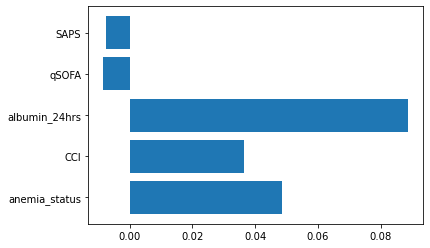

In [19]:
# general quick feature importance
# get coefficients for importance
# coefficients represent the log odds that an observation is in the
# target class, given the values of its X variables

importance = logreg.coef_[0]
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

               Importance
albumin_24hrs    1.092662
anemia_status    1.049742
CCI              1.037143
SAPS             0.992431
qSOFA            0.991696


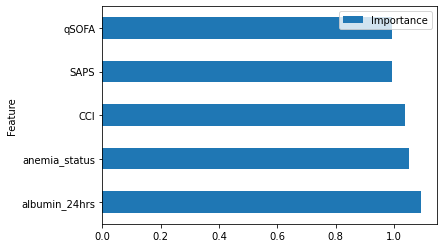

In [20]:
# convert log odds into regular odds with exponentiation
# np.exp()
# and list values, visualize in bar plot

odds = np.exp(logreg.coef_[0])
feature_importance = \
            pd.DataFrame(odds, 
             X.columns, 
             columns=['Importance'])\
            .sort_values(by='Importance', ascending=False)
        
ax = feature_importance.plot.barh(xlabel='Feature', ylabel='Importance')
print(feature_importance)
plt.show()

In [21]:
# Generate model prediction data for train and test sets
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

In [22]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[19240 15102]
 [15655 18687]]


In [23]:
# model metrics for training set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.55      0.56      0.56     34342
           1       0.55      0.54      0.55     34342

    accuracy                           0.55     68684
   macro avg       0.55      0.55      0.55     68684
weighted avg       0.55      0.55      0.55     68684



In [24]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[4722 3788]
 [1754 1958]]


In [25]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.73      0.55      0.63      8510
           1       0.34      0.53      0.41      3712

    accuracy                           0.55     12222
   macro avg       0.53      0.54      0.52     12222
weighted avg       0.61      0.55      0.56     12222



## 1: Decision Tree (Max Depth=3)

In [26]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
dt = tree.DecisionTreeClassifier(max_depth=3)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

Feature: anemia_status Score: 0.00000
Feature: CCI Score: 0.55454
Feature: albumin_24hrs Score: 0.03804
Feature: qSOFA Score: 0.00000
Feature: SAPS Score: 0.40742


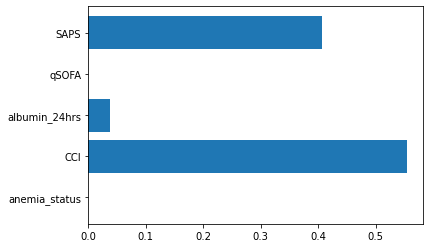

In [27]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [28]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [29]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[16155 18187]
 [12119 22223]]


In [30]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.57      0.47      0.52     34342
           1       0.55      0.65      0.59     34342

    accuracy                           0.56     68684
   macro avg       0.56      0.56      0.56     68684
weighted avg       0.56      0.56      0.56     68684



In [31]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[3992 4518]
 [1450 2262]]


In [32]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.73      0.47      0.57      8510
           1       0.33      0.61      0.43      3712

    accuracy                           0.51     12222
   macro avg       0.53      0.54      0.50     12222
weighted avg       0.61      0.51      0.53     12222



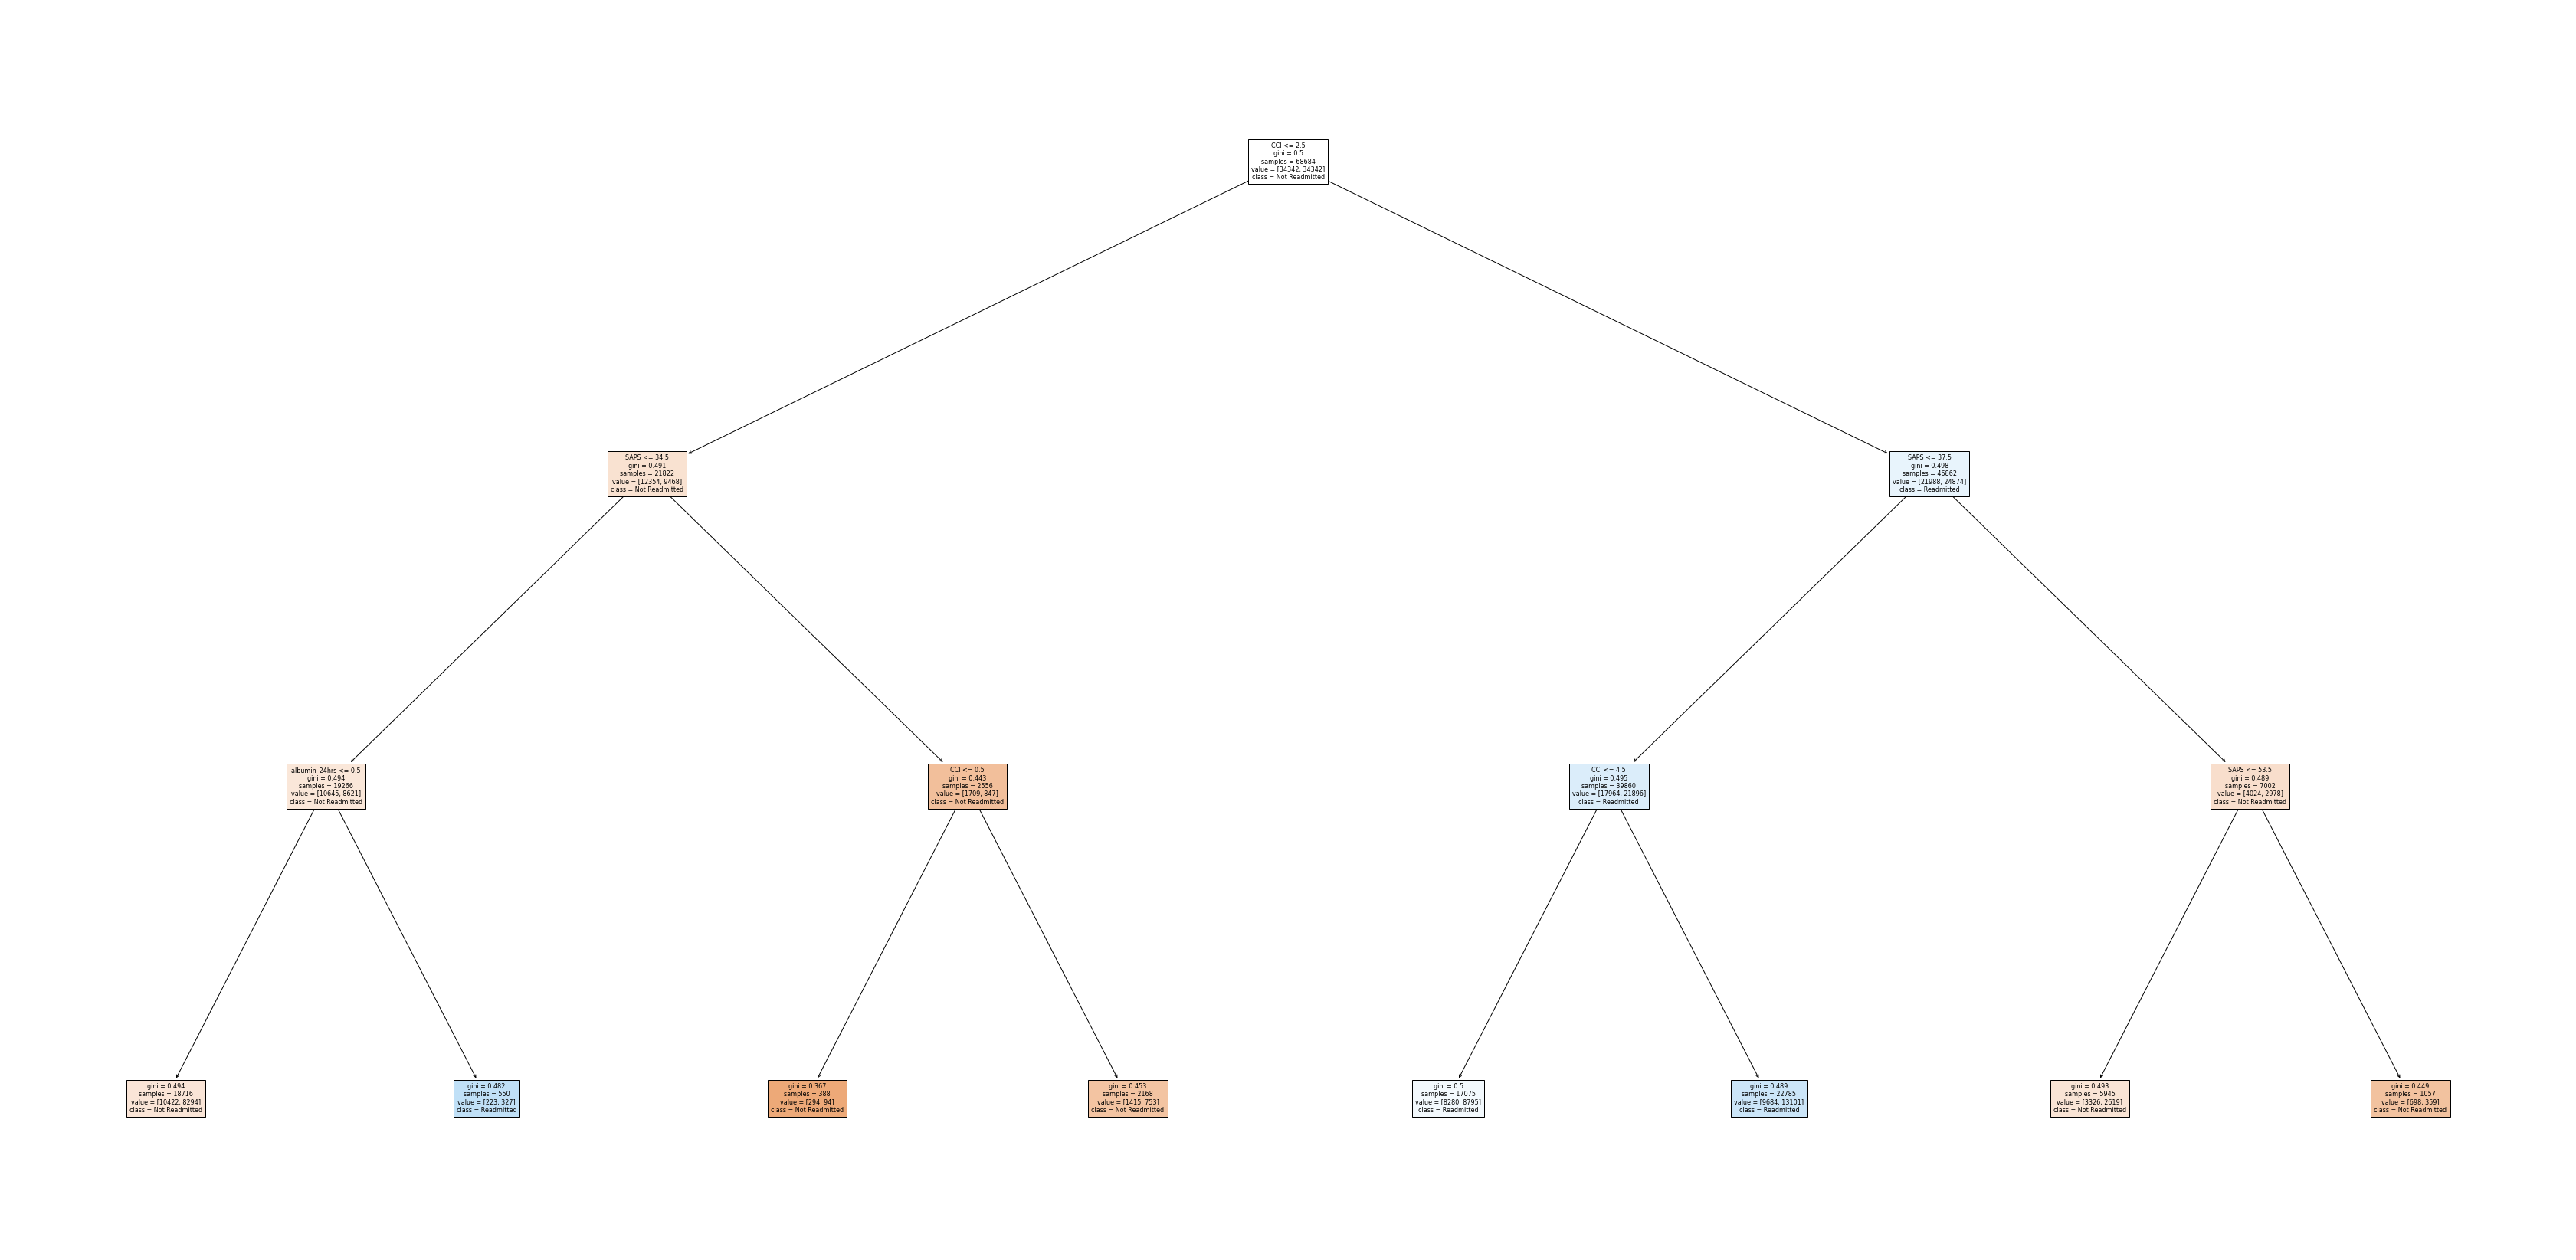

In [33]:
feature_names = X_train.columns.tolist()
class_names = ['Not Readmitted', 'Readmitted']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

#### dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('30DRA_DT_D3_NCBL.png')

## 2: Decision Tree (Max Depth=4)

In [34]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
dt = tree.DecisionTreeClassifier(max_depth=4)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

Feature: anemia_status Score: 0.07499
Feature: CCI Score: 0.49549
Feature: albumin_24hrs Score: 0.05117
Feature: qSOFA Score: 0.00000
Feature: SAPS Score: 0.37835


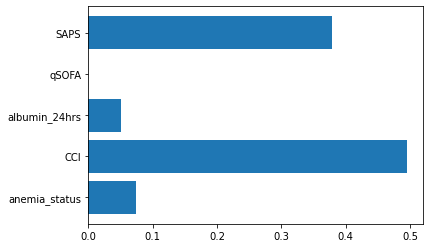

In [35]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [36]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [37]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[16155 18187]
 [12119 22223]]


In [38]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.57      0.47      0.52     34342
           1       0.55      0.65      0.59     34342

    accuracy                           0.56     68684
   macro avg       0.56      0.56      0.56     68684
weighted avg       0.56      0.56      0.56     68684



In [39]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[3992 4518]
 [1450 2262]]


In [40]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.73      0.47      0.57      8510
           1       0.33      0.61      0.43      3712

    accuracy                           0.51     12222
   macro avg       0.53      0.54      0.50     12222
weighted avg       0.61      0.51      0.53     12222



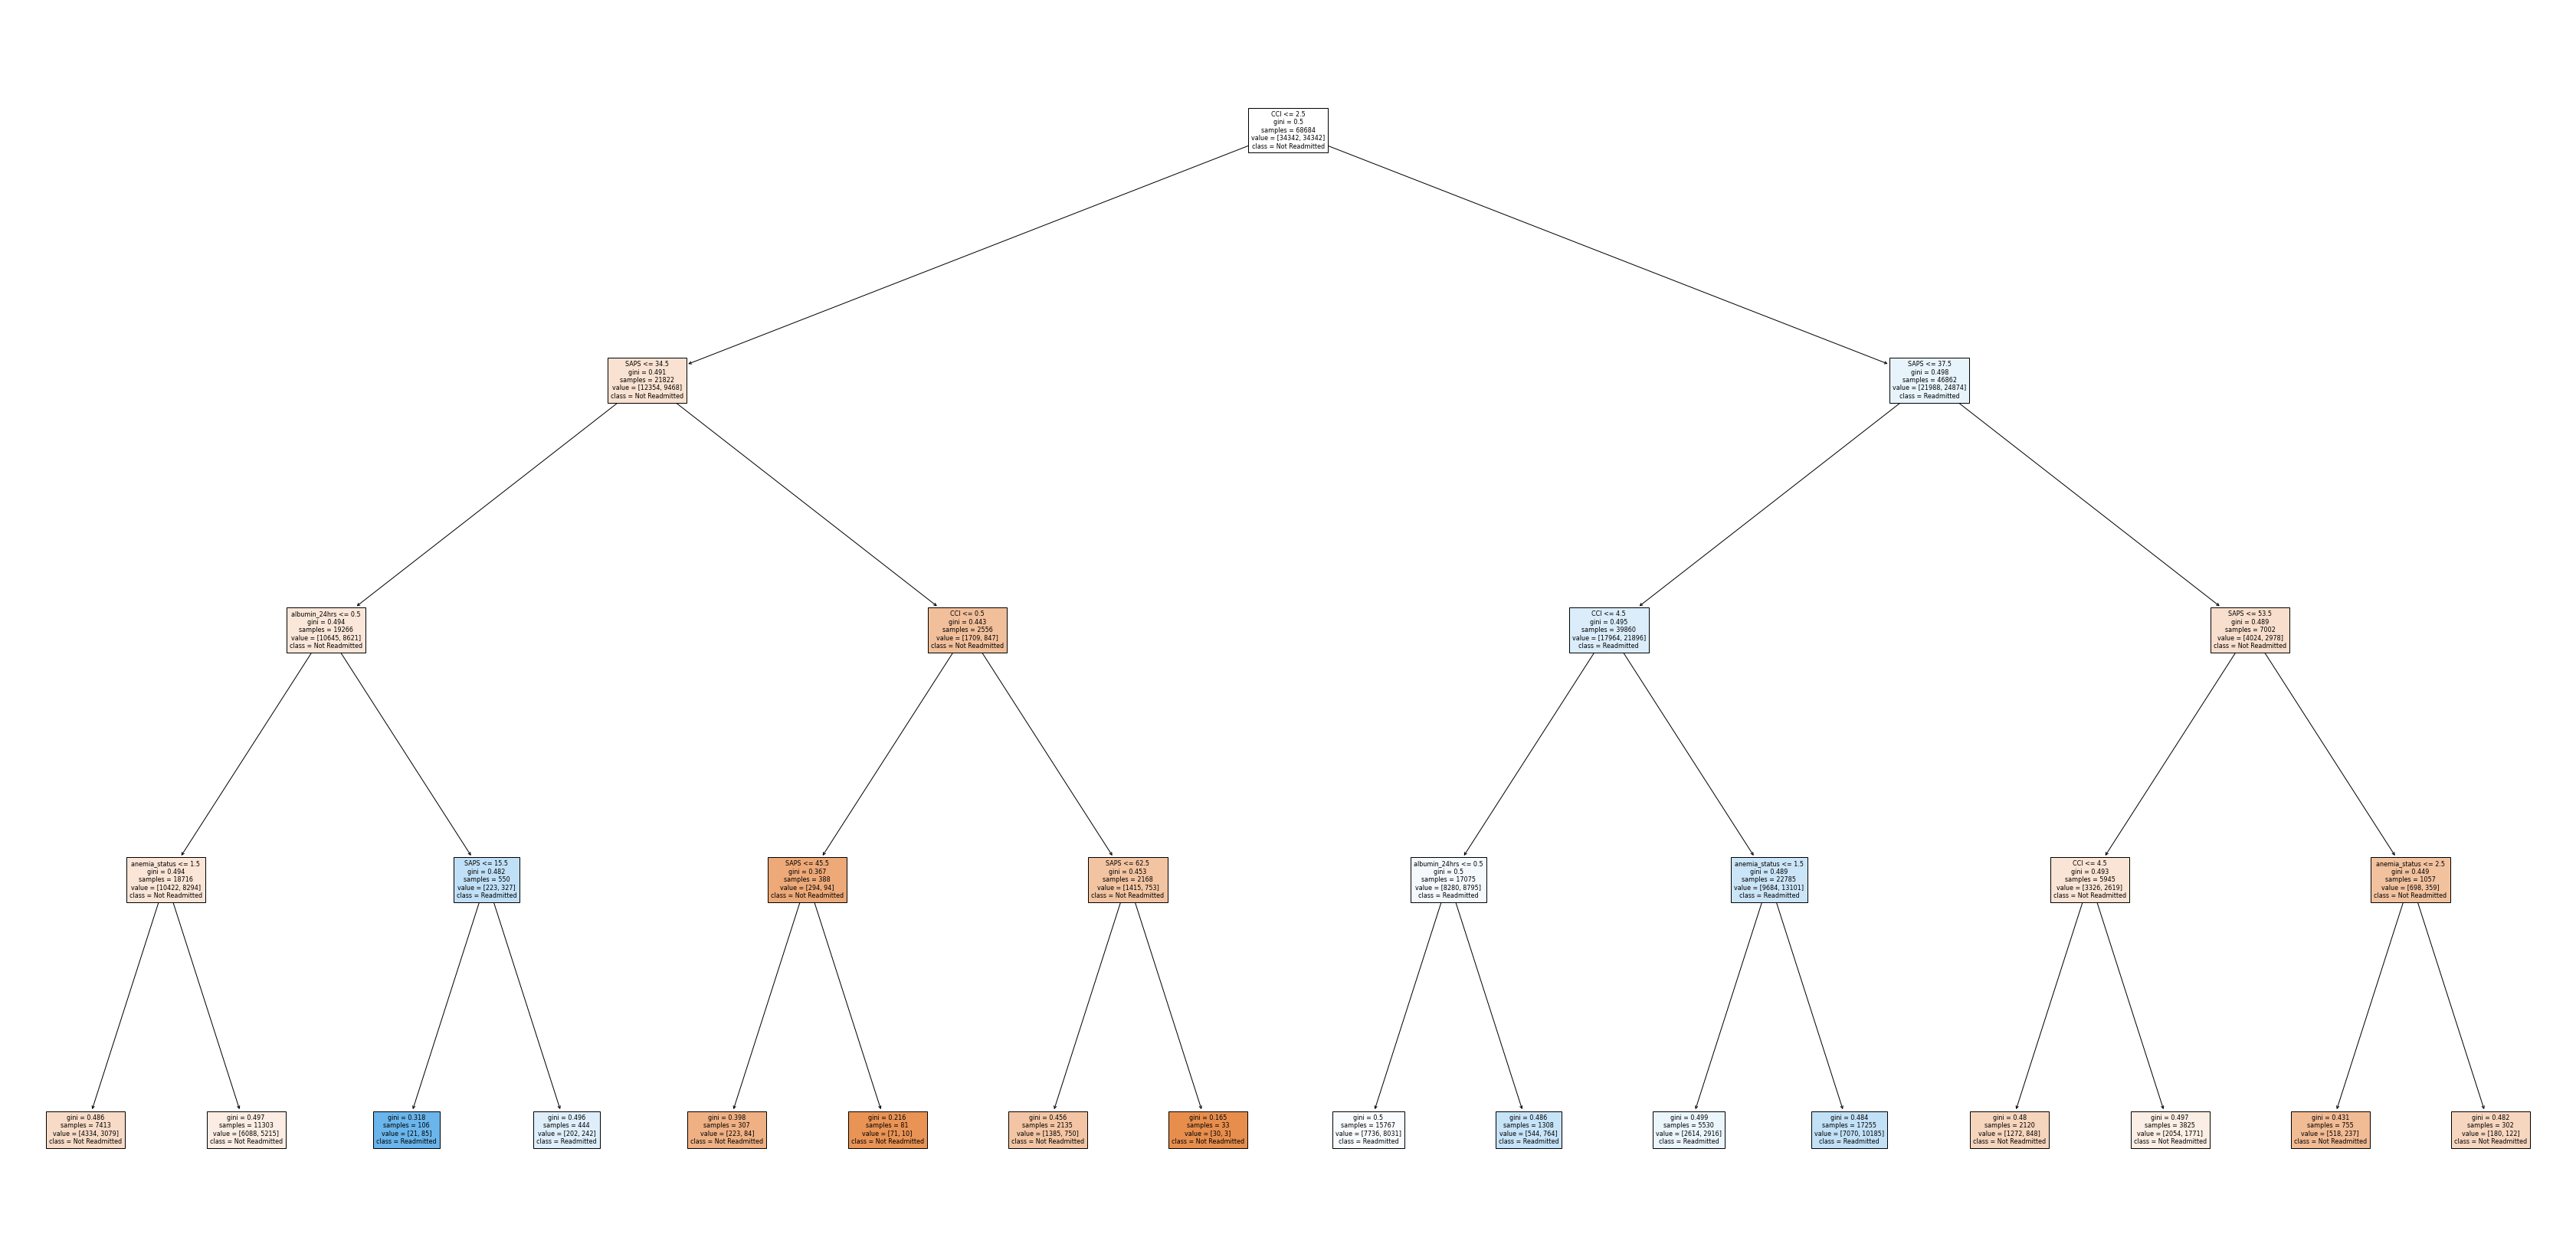

In [41]:
feature_names = X_train.columns.tolist()
class_names = ['Not Readmitted', 'Readmitted']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [42]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('30DRA_DT_D4_NCBL.png')

True

## 3: Decision Tree 

In [43]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
# max_depth 5
dt = tree.DecisionTreeClassifier(max_depth=5)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

Feature: anemia_status Score: 0.09769
Feature: CCI Score: 0.43838
Feature: albumin_24hrs Score: 0.04436
Feature: qSOFA Score: 0.01766
Feature: SAPS Score: 0.40191


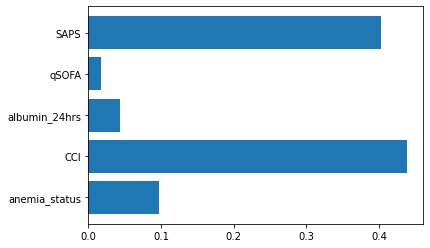

In [44]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [45]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [46]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[18999 15343]
 [14756 19586]]


In [47]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.56      0.55      0.56     34342
           1       0.56      0.57      0.57     34342

    accuracy                           0.56     68684
   macro avg       0.56      0.56      0.56     68684
weighted avg       0.56      0.56      0.56     68684



In [48]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[4719 3791]
 [1730 1982]]


In [49]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.73      0.55      0.63      8510
           1       0.34      0.53      0.42      3712

    accuracy                           0.55     12222
   macro avg       0.54      0.54      0.52     12222
weighted avg       0.61      0.55      0.57     12222



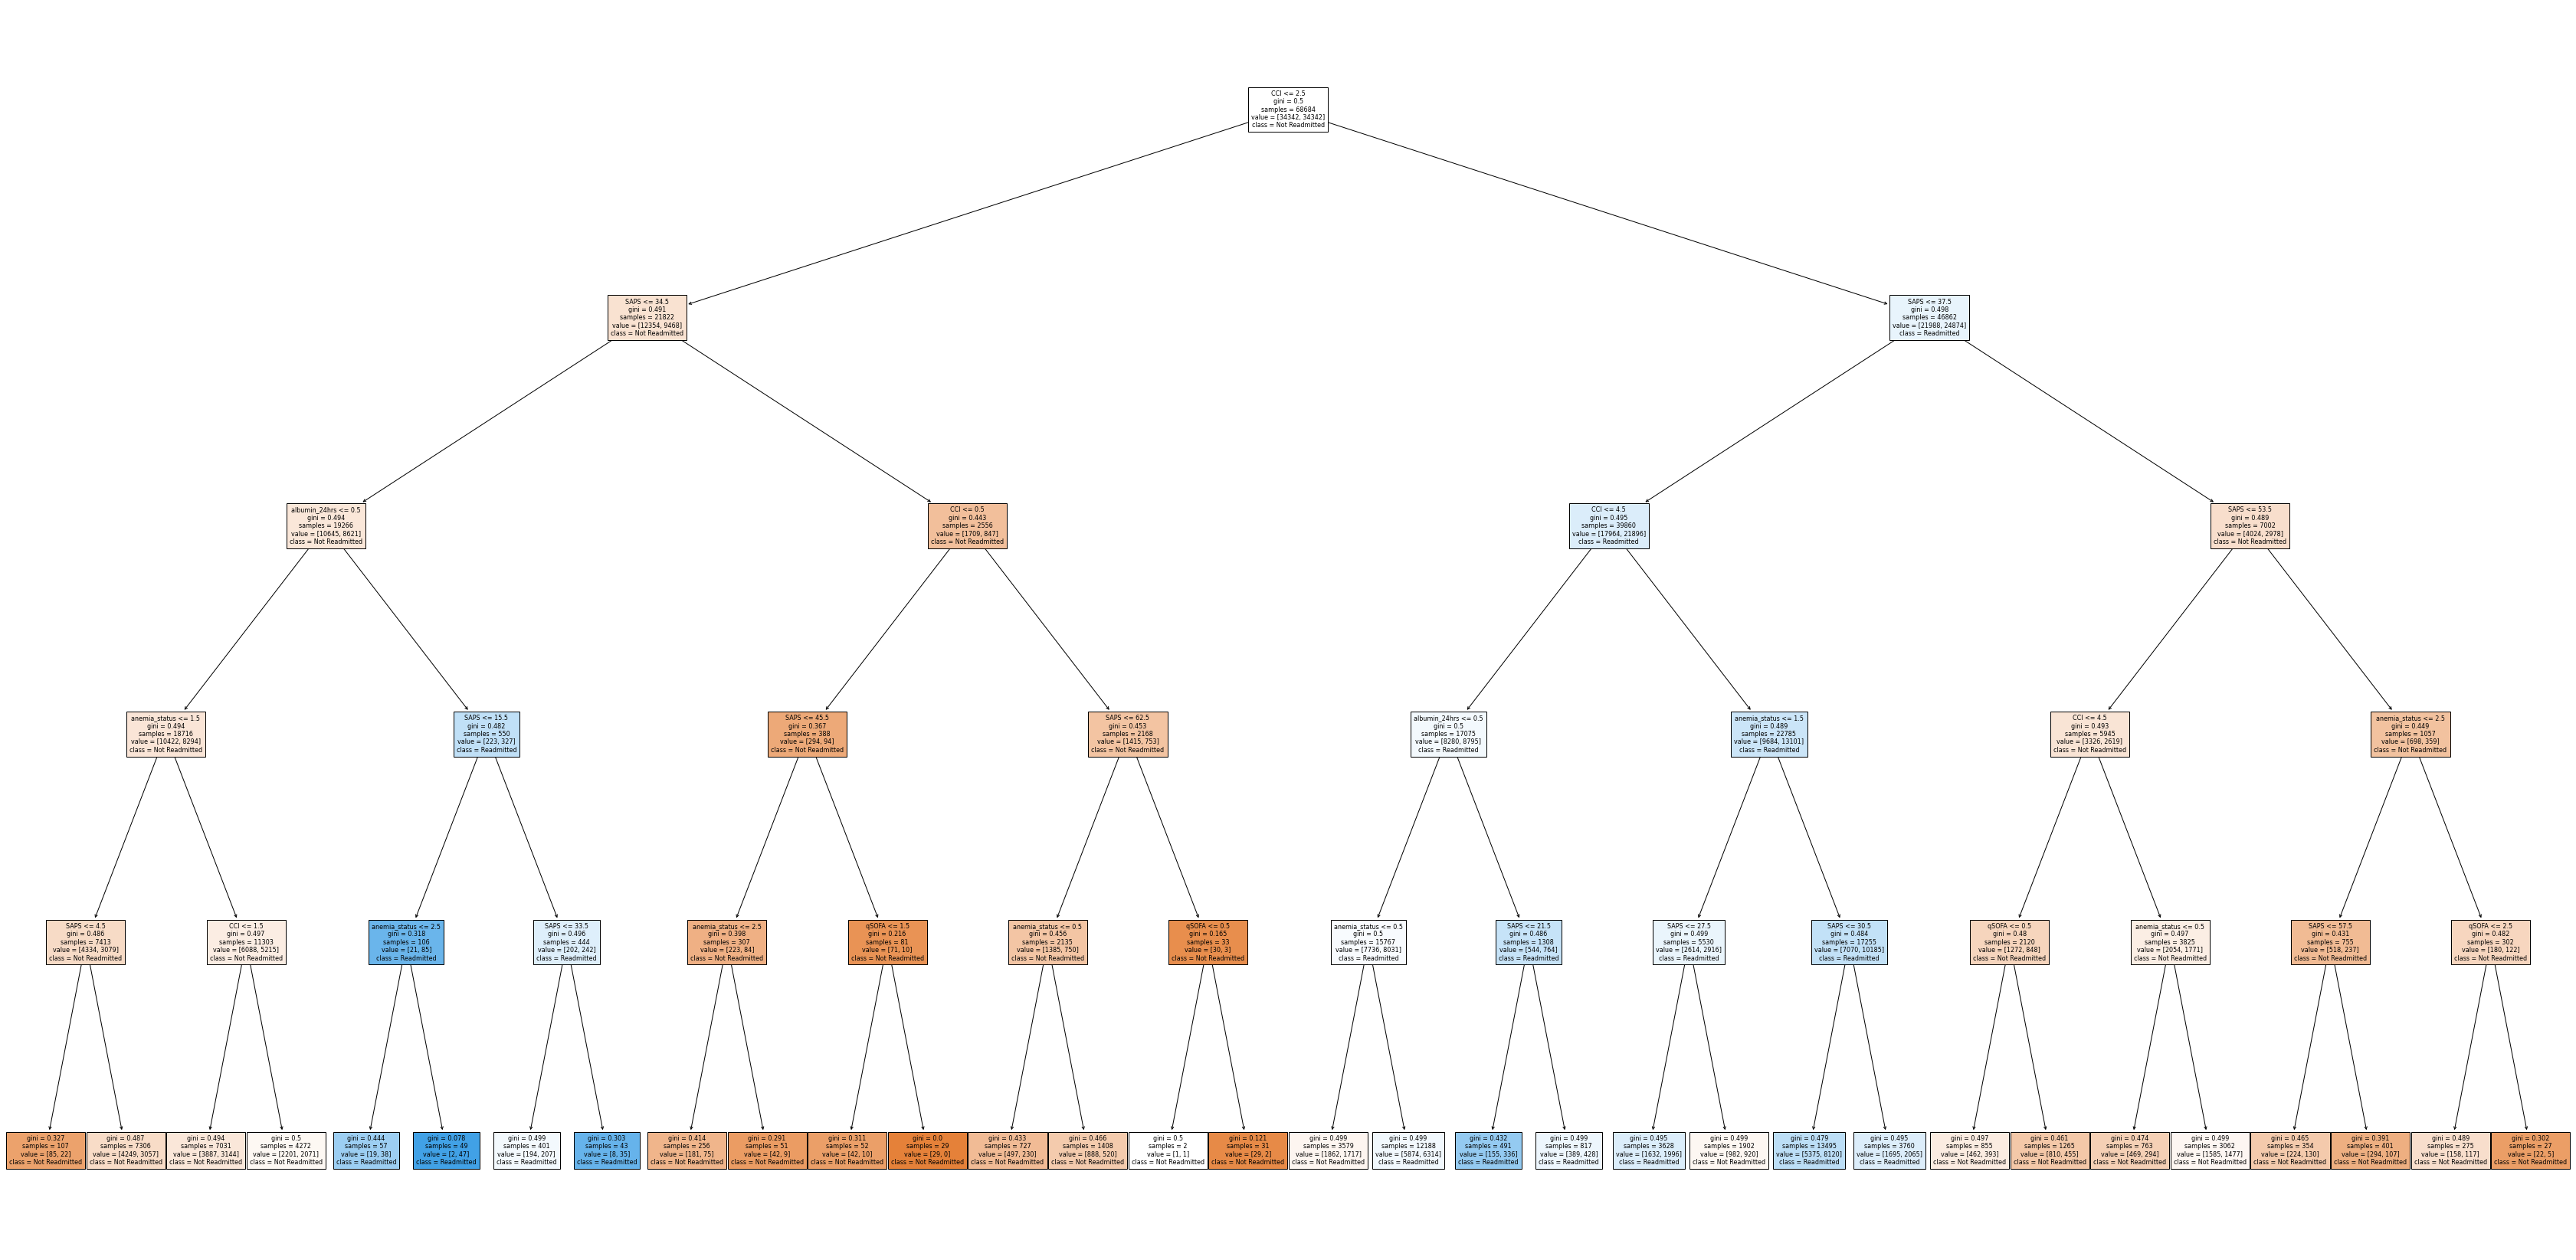

In [50]:
feature_names = X_train.columns.tolist()
class_names = ['Not Readmitted', 'Readmitted']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [51]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('30DRA_DT_D5_NCBL.png')

True

## 4: Decision Tree 

In [52]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
# max_depth 5
dt = tree.DecisionTreeClassifier(max_depth=6, min_samples_leaf=100)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=100)

Feature: anemia_status Score: 0.09001
Feature: CCI Score: 0.41873
Feature: albumin_24hrs Score: 0.06489
Feature: qSOFA Score: 0.03504
Feature: SAPS Score: 0.39134


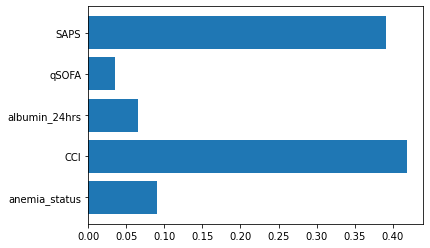

In [53]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [54]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [55]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[16917 17425]
 [12495 21847]]


In [56]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.58      0.49      0.53     34342
           1       0.56      0.64      0.59     34342

    accuracy                           0.56     68684
   macro avg       0.57      0.56      0.56     68684
weighted avg       0.57      0.56      0.56     68684



In [57]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[4173 4337]
 [1491 2221]]


In [58]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.74      0.49      0.59      8510
           1       0.34      0.60      0.43      3712

    accuracy                           0.52     12222
   macro avg       0.54      0.54      0.51     12222
weighted avg       0.62      0.52      0.54     12222



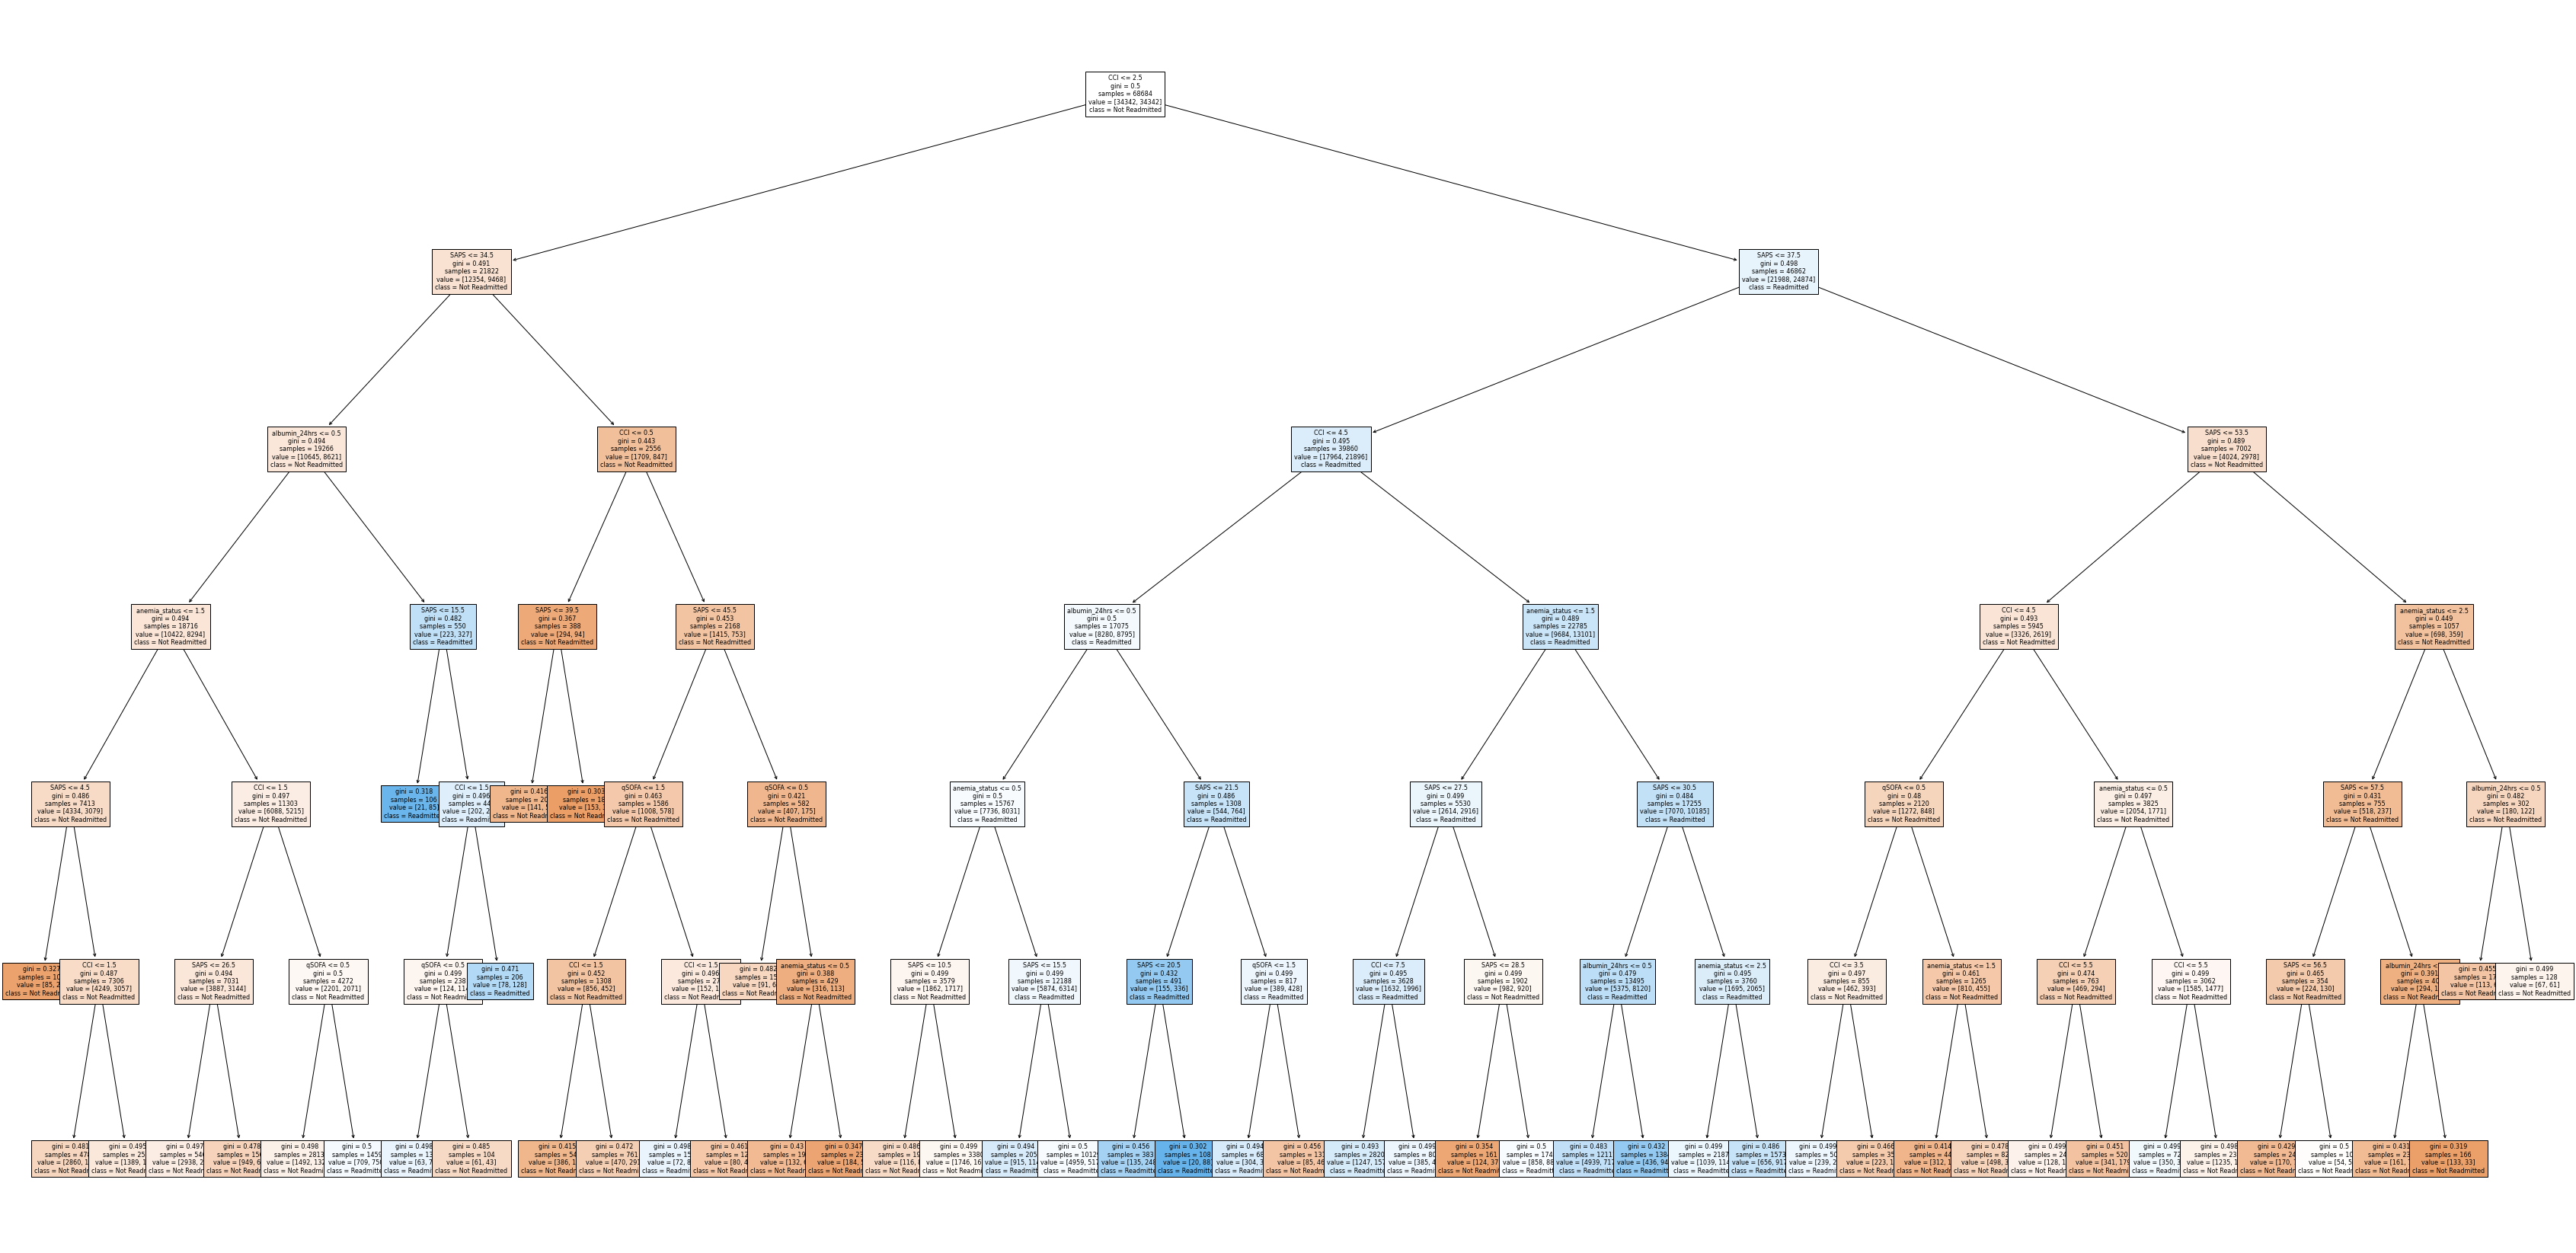

In [59]:
feature_names = X_train.columns.tolist()
class_names = ['Not Readmitted', 'Readmitted']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [60]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('30DRA_DT_D6_NCBL.png')

True

## 5: Decision Tree 

In [61]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
# max_depth 5
dt = tree.DecisionTreeClassifier(max_depth=7, min_samples_leaf=100)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=100)

Feature: anemia_status Score: 0.10559
Feature: CCI Score: 0.41206
Feature: albumin_24hrs Score: 0.06074
Feature: qSOFA Score: 0.04654
Feature: SAPS Score: 0.37507


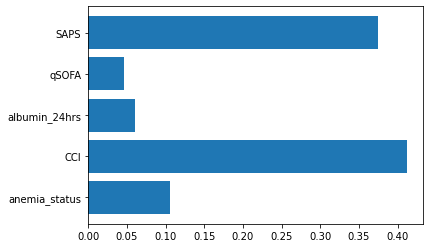

In [62]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [63]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [64]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[20380 13962]
 [15652 18690]]


In [65]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.57      0.59      0.58     34342
           1       0.57      0.54      0.56     34342

    accuracy                           0.57     68684
   macro avg       0.57      0.57      0.57     68684
weighted avg       0.57      0.57      0.57     68684



In [66]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[4965 3545]
 [1858 1854]]


In [67]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.73      0.58      0.65      8510
           1       0.34      0.50      0.41      3712

    accuracy                           0.56     12222
   macro avg       0.54      0.54      0.53     12222
weighted avg       0.61      0.56      0.57     12222



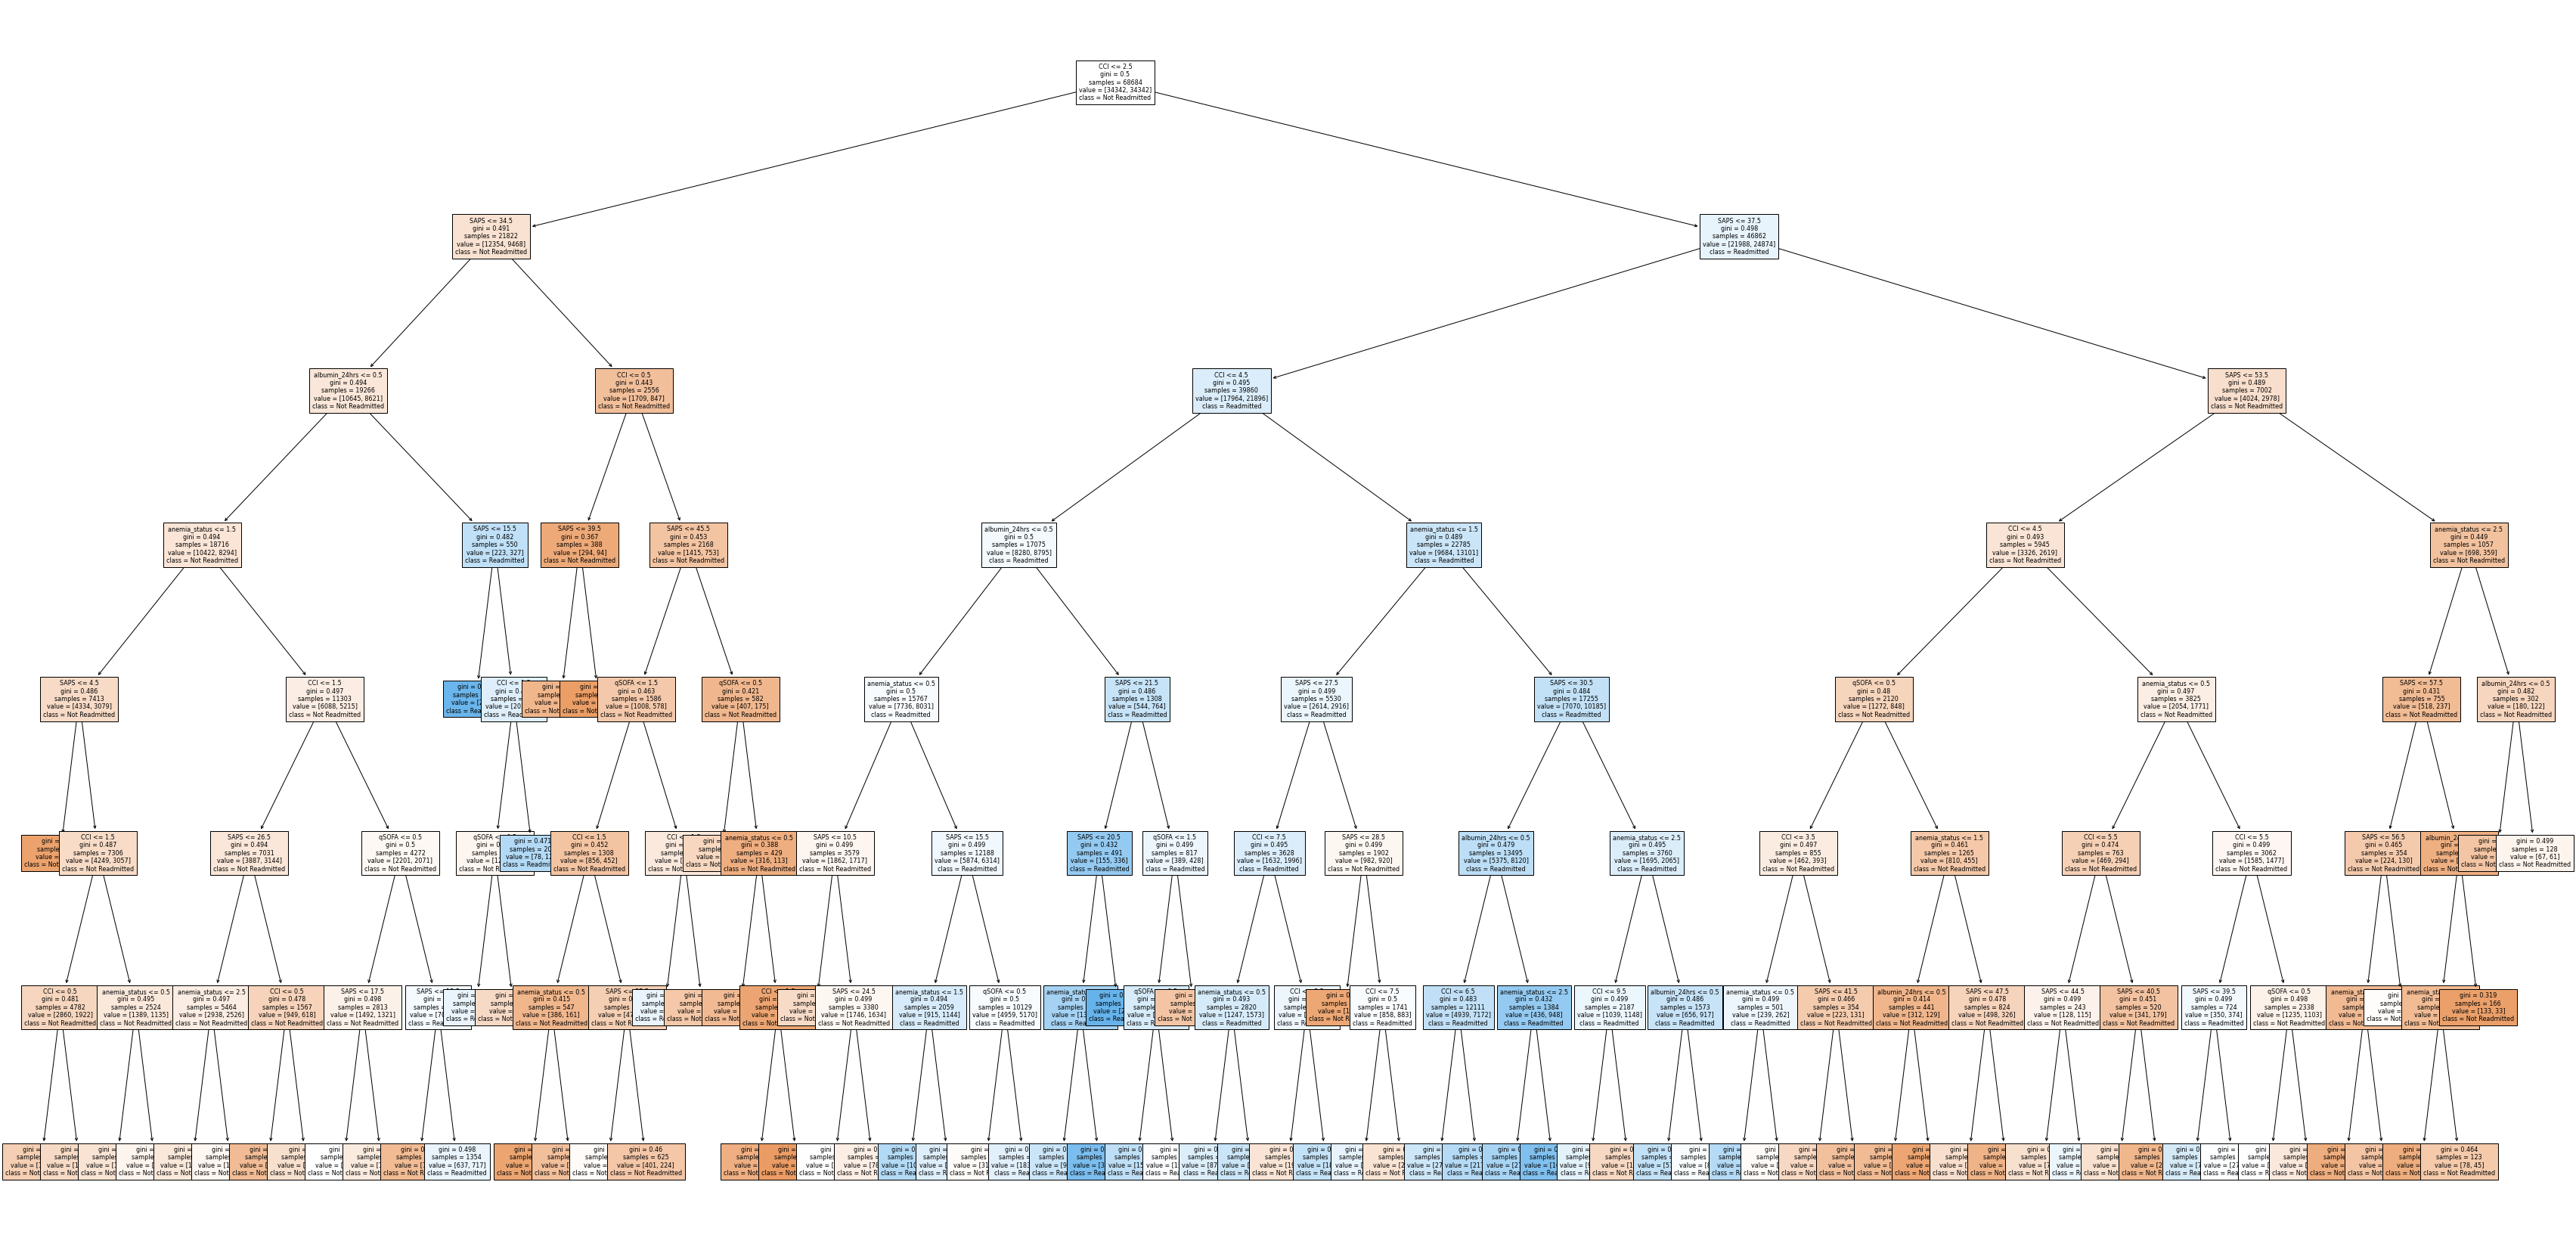

In [68]:
feature_names = X_train.columns.tolist()
class_names = ['Not Readmitted', 'Readmitted']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [69]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('30DRA_DT_D7_NCBL.png')

True

## 6: Decision Tree 

In [70]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
# max_depth 5
dt = tree.DecisionTreeClassifier(max_depth=8, min_samples_leaf=100)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=100)

Feature: anemia_status Score: 0.10807
Feature: CCI Score: 0.39441
Feature: albumin_24hrs Score: 0.05326
Feature: qSOFA Score: 0.04695
Feature: SAPS Score: 0.39730


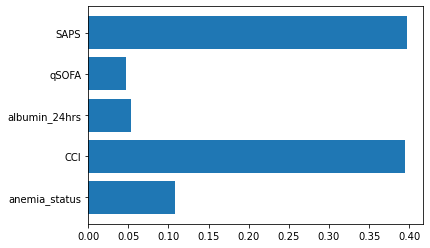

In [71]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [72]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [73]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[19128 15214]
 [14050 20292]]


In [74]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.58      0.56      0.57     34342
           1       0.57      0.59      0.58     34342

    accuracy                           0.57     68684
   macro avg       0.57      0.57      0.57     68684
weighted avg       0.57      0.57      0.57     68684



In [75]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[4637 3873]
 [1764 1948]]


In [76]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.72      0.54      0.62      8510
           1       0.33      0.52      0.41      3712

    accuracy                           0.54     12222
   macro avg       0.53      0.53      0.52     12222
weighted avg       0.61      0.54      0.56     12222



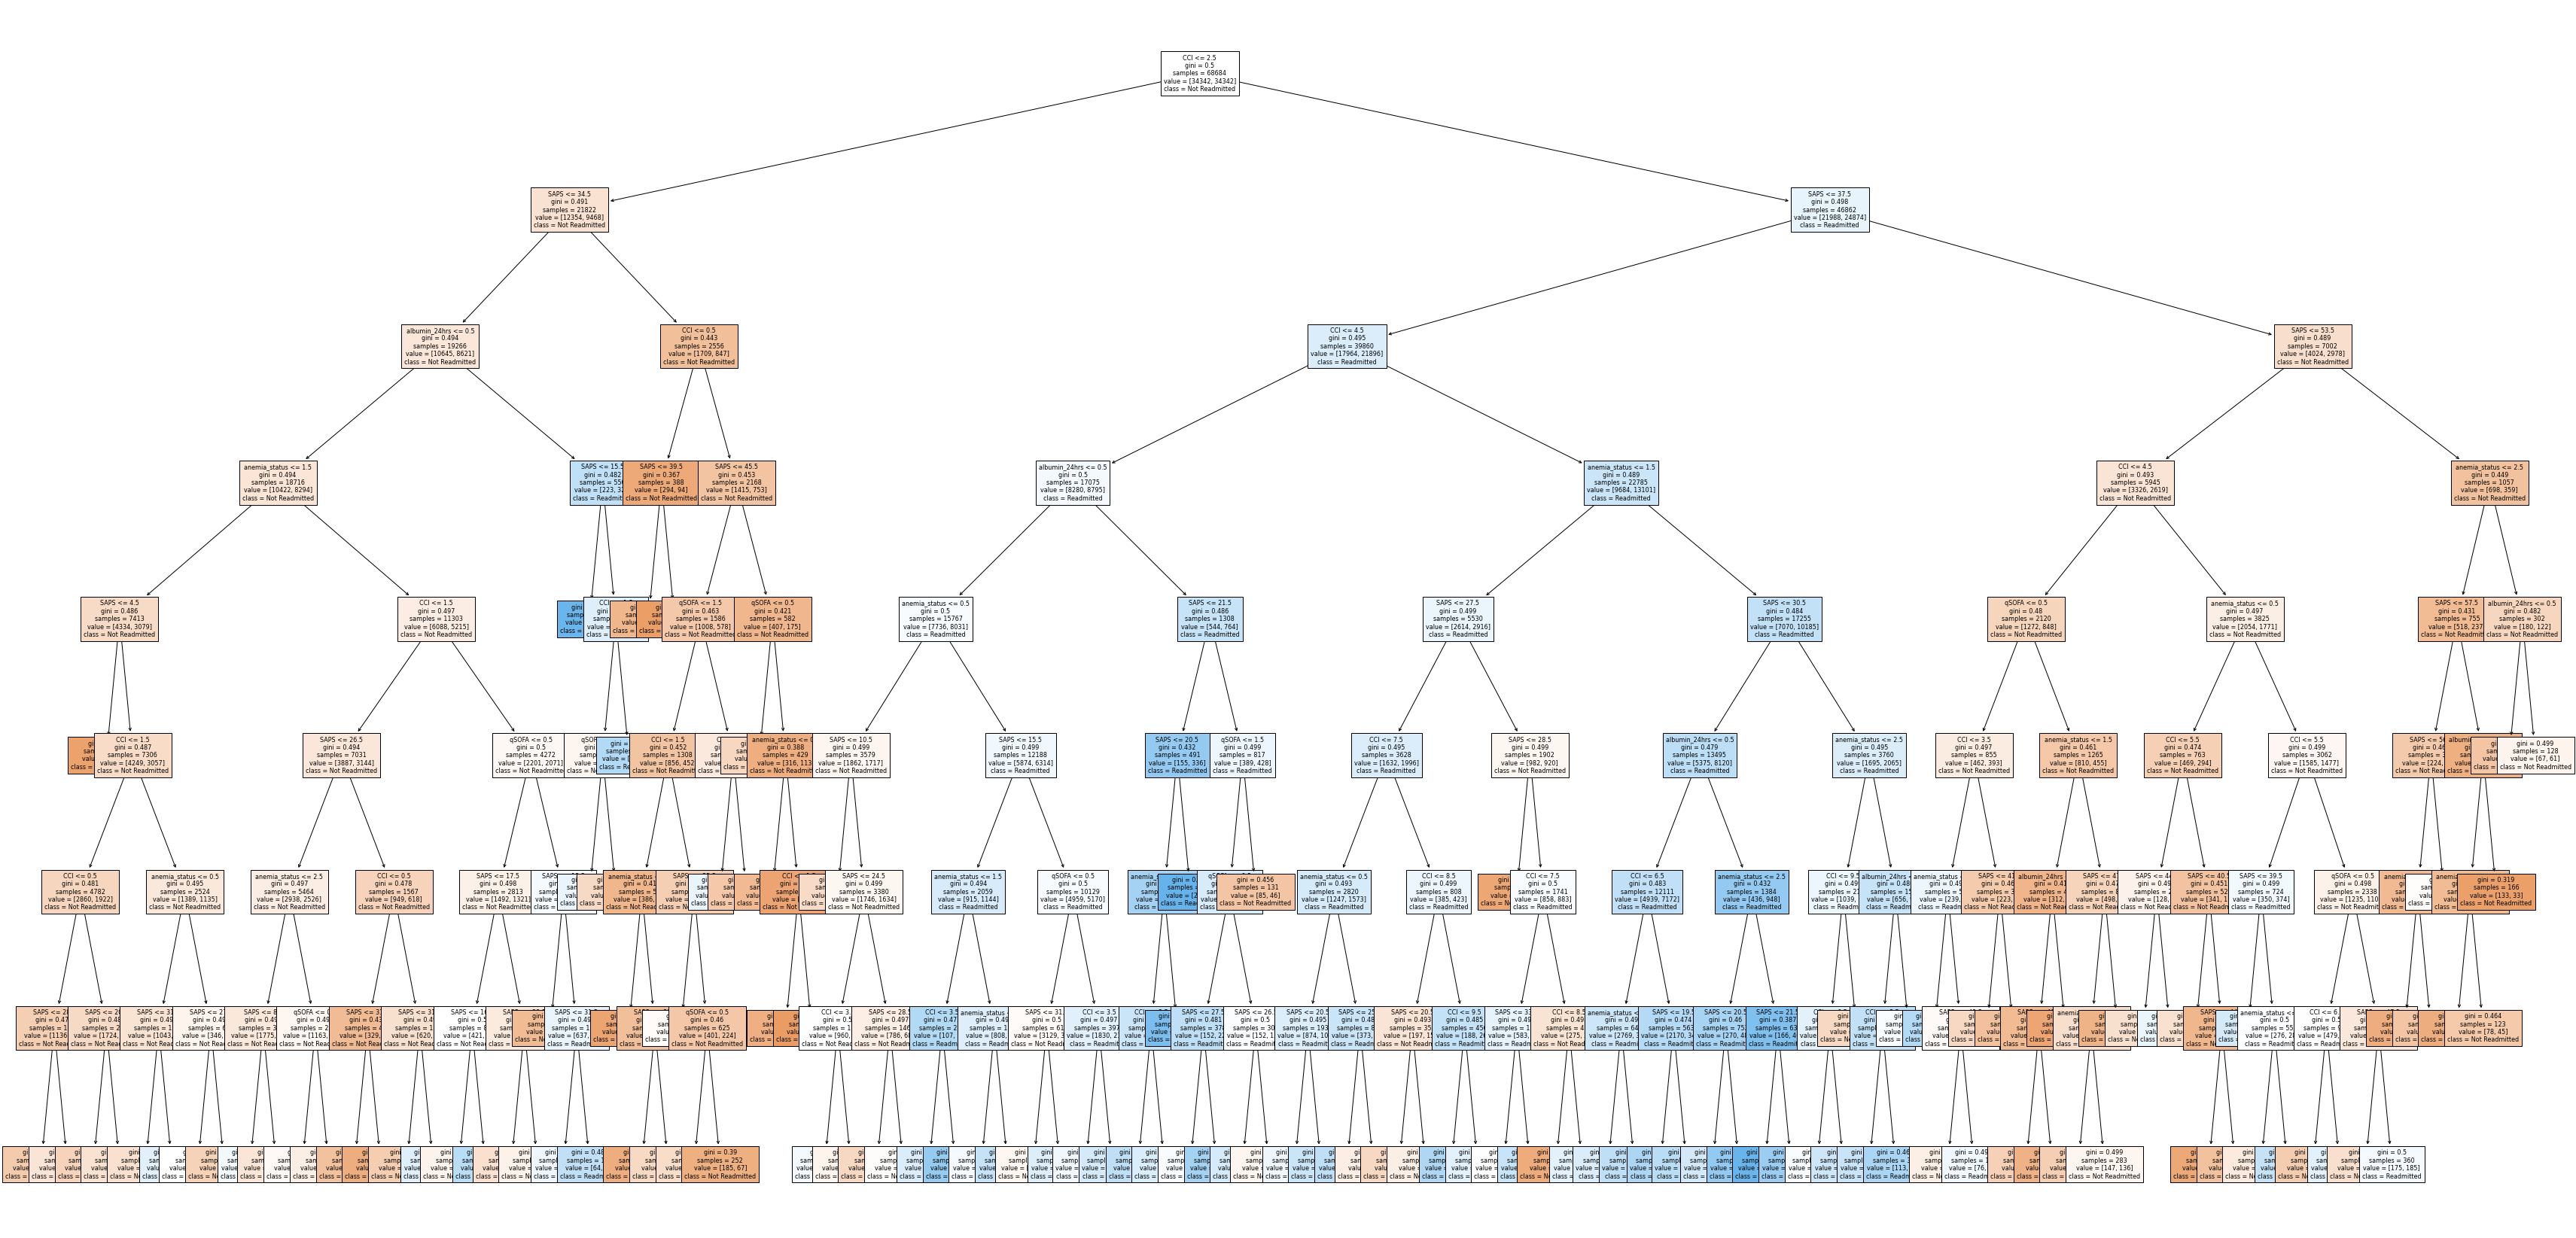

In [77]:
feature_names = X_train.columns.tolist()
class_names = ['Not Readmitted', 'Readmitted']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [78]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('30DRA_DT_D8_NCBL.png')

True

## Random Forest

In [79]:
rf = RandomForestClassifier(max_depth=8, min_samples_leaf=100)
# fit the model to X and y training sets
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=100)

In [80]:
# generate model prediction data for train and test sets
y_hat_train = rf.predict(X_train)
y_hat_test = rf.predict(X_test)

In [81]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[19668 14674]
 [14540 19802]]


In [82]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.57      0.57      0.57     34342
           1       0.57      0.58      0.58     34342

    accuracy                           0.57     68684
   macro avg       0.57      0.57      0.57     68684
weighted avg       0.57      0.57      0.57     68684



In [83]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[4861 3649]
 [1780 1932]]


In [84]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.73      0.57      0.64      8510
           1       0.35      0.52      0.42      3712

    accuracy                           0.56     12222
   macro avg       0.54      0.55      0.53     12222
weighted avg       0.61      0.56      0.57     12222



Feature: anemia_status Score: 0.12464
Feature: CCI Score: 0.40683
Feature: albumin_24hrs Score: 0.04143
Feature: qSOFA Score: 0.05016
Feature: SAPS Score: 0.37694


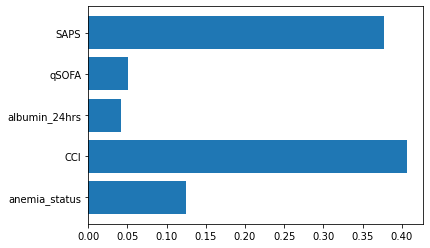

In [85]:
# get importance from decision tree model
importance = rf.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()